Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Accuracy: 0.9246575342465754
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.22      0.22      0.22        50

    accuracy                           0.92      1022
   macro avg       0.59      0.59      0.59      1022
weighted avg       0.92      0.92      0.92      1022

ROC AUC Score: 0.8158436213991769


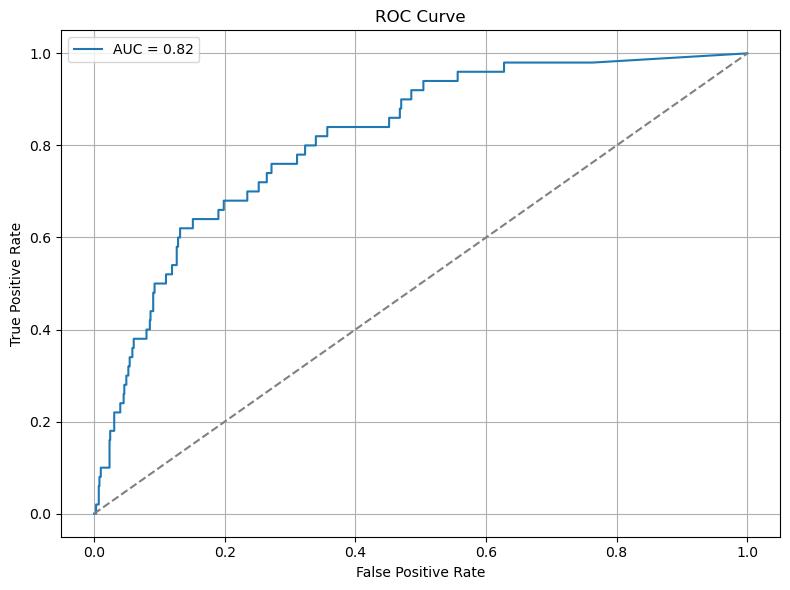

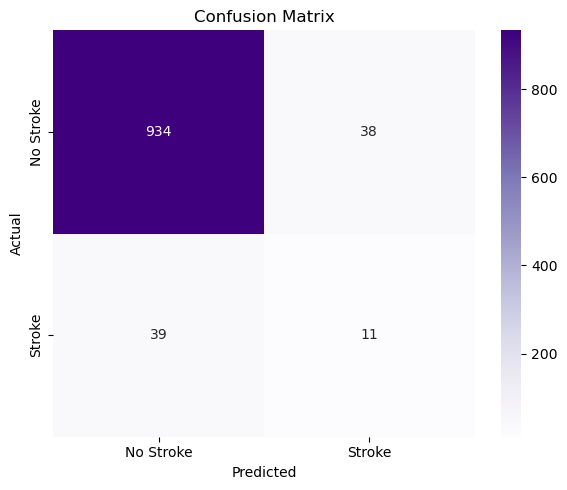

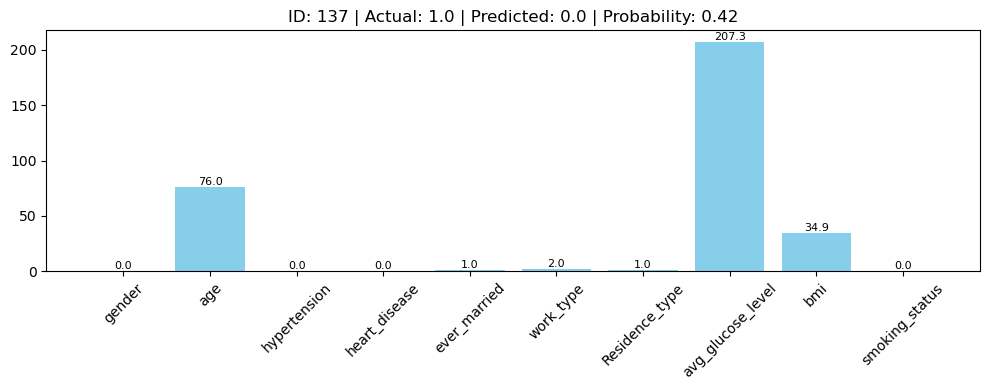

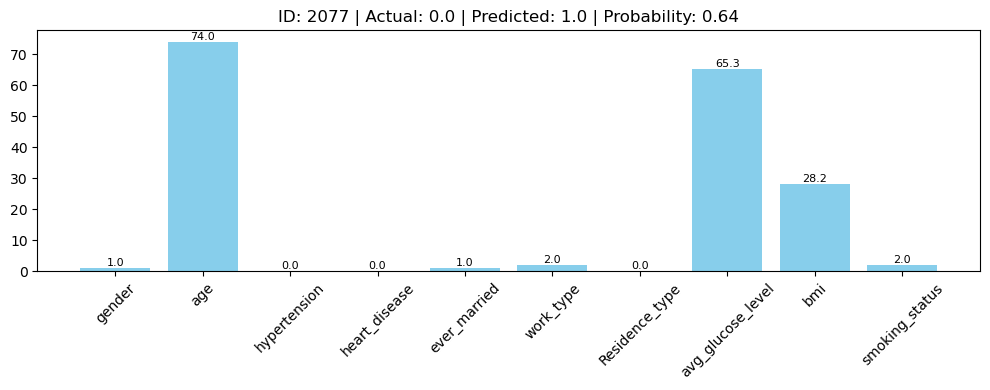

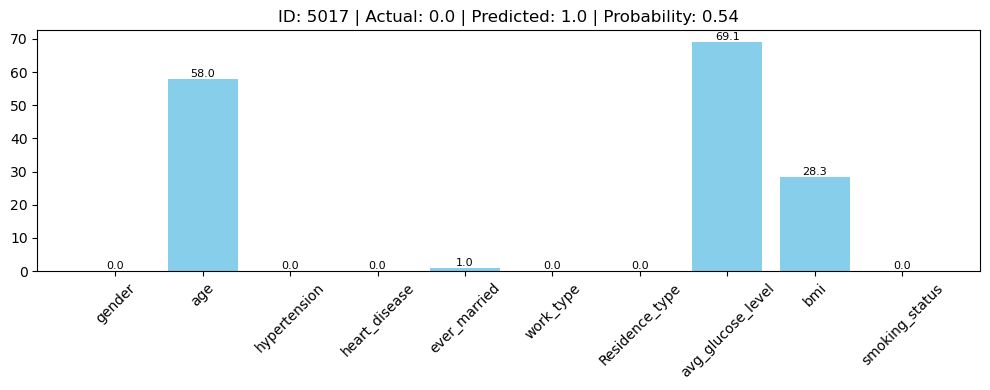

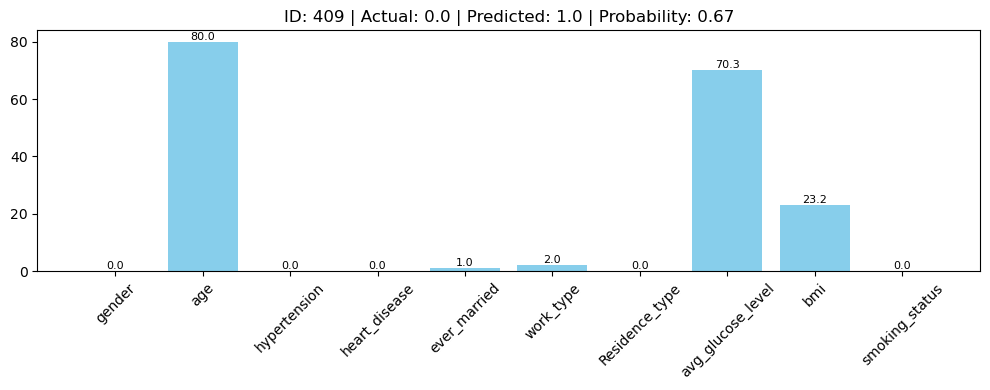

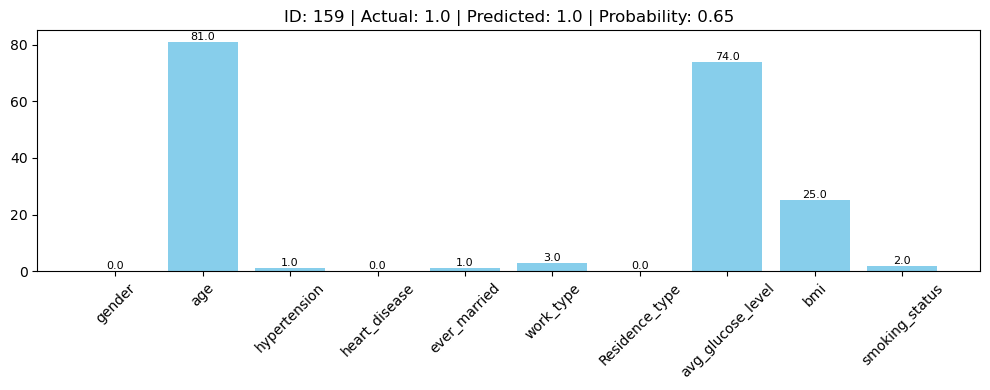

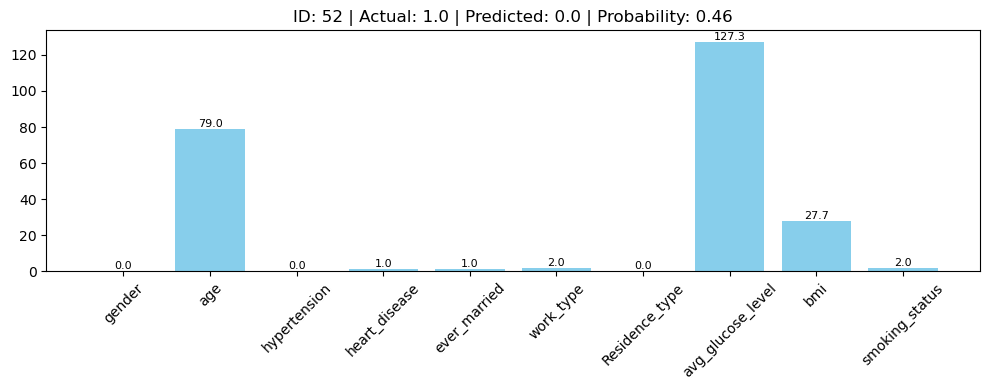

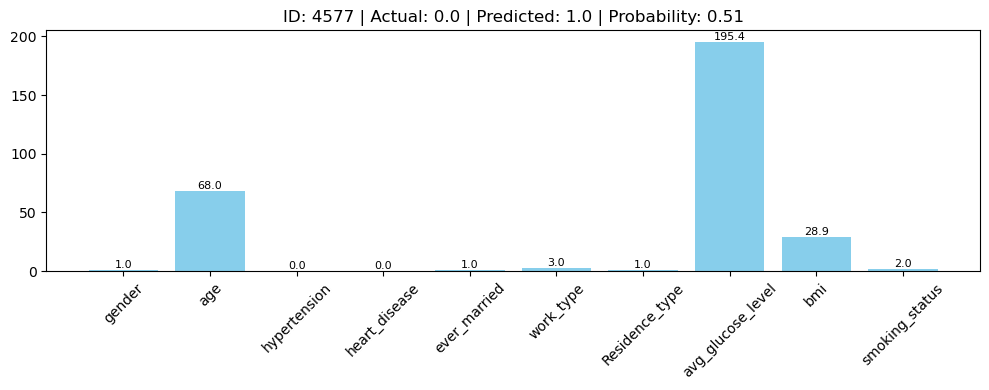

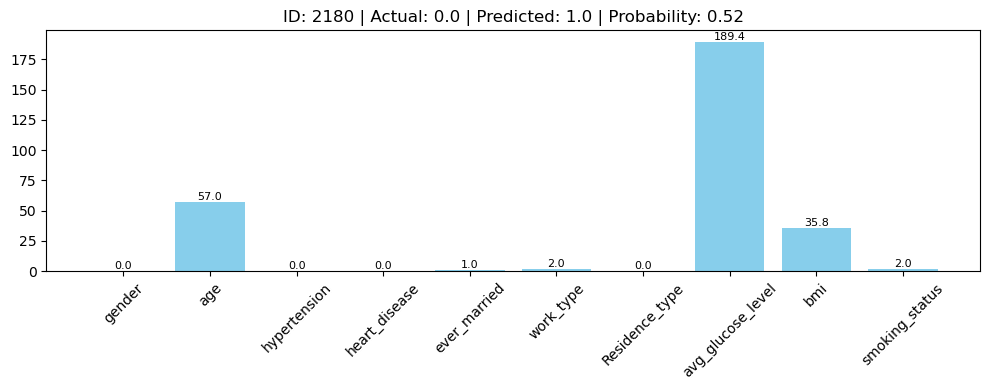

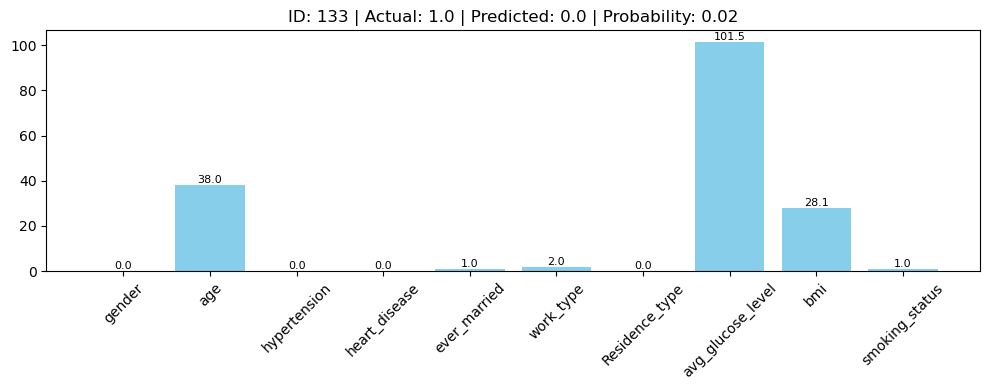

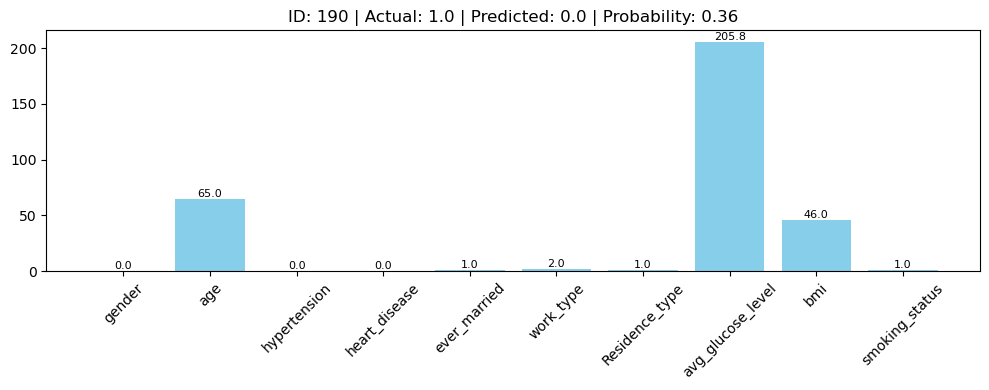

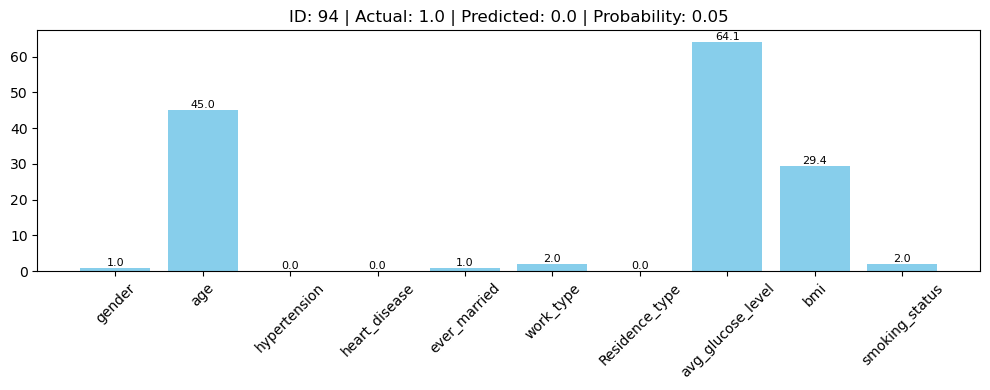

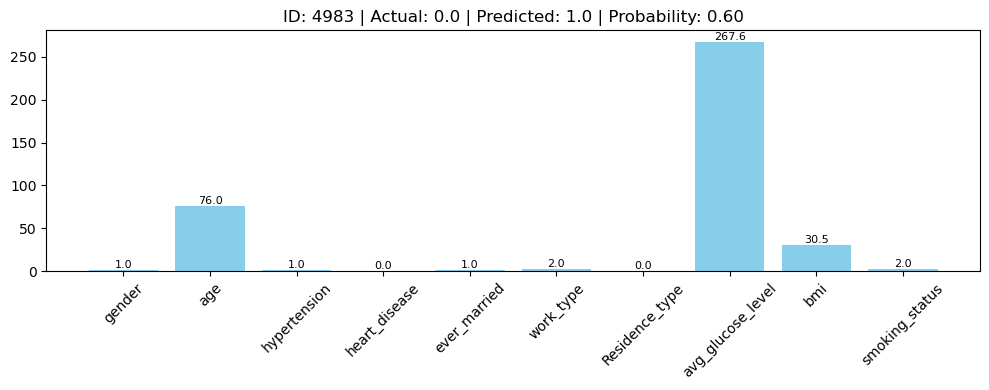

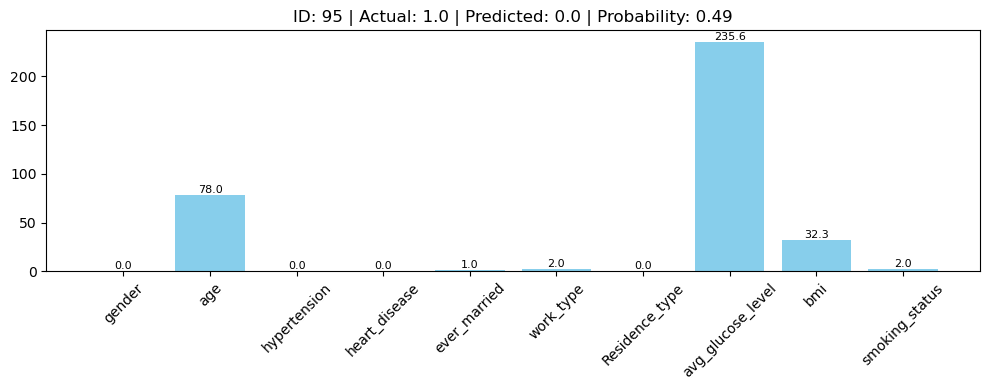

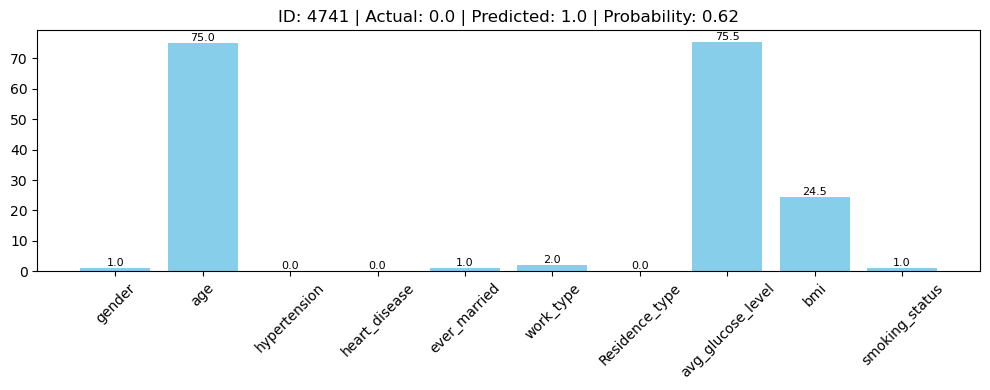

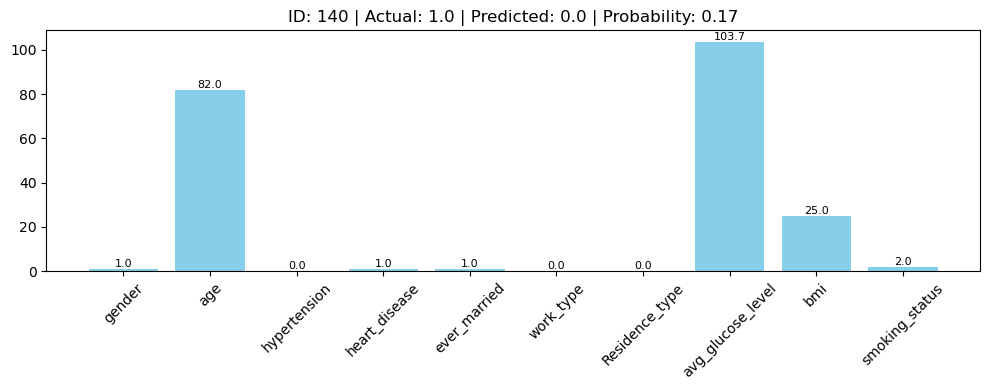

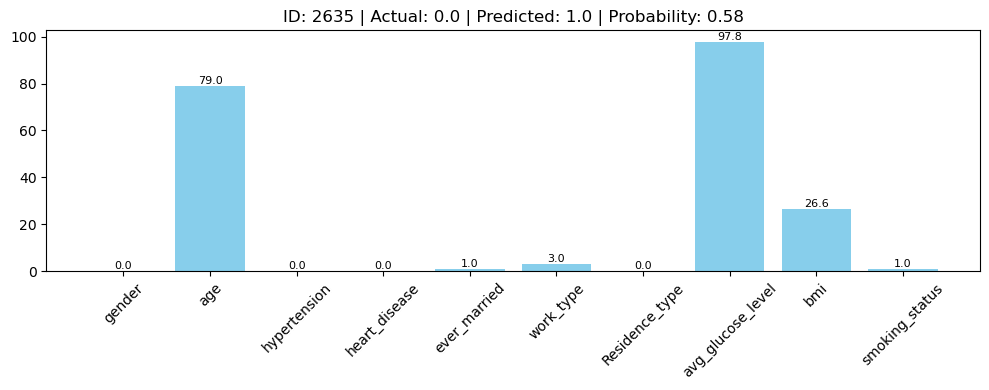

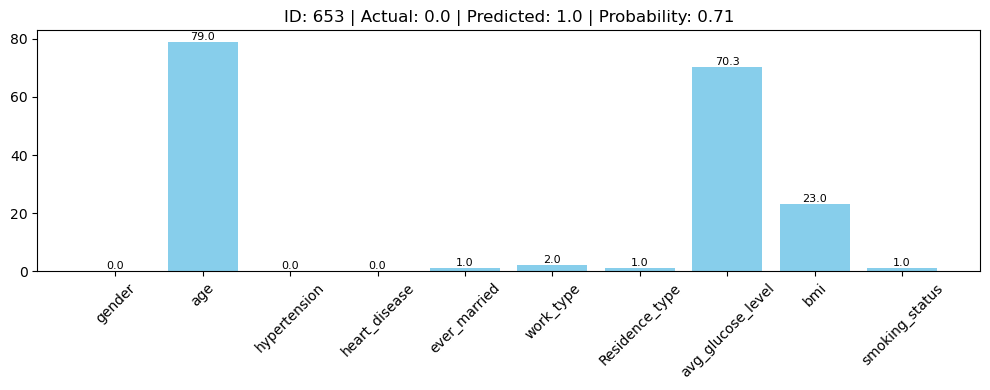

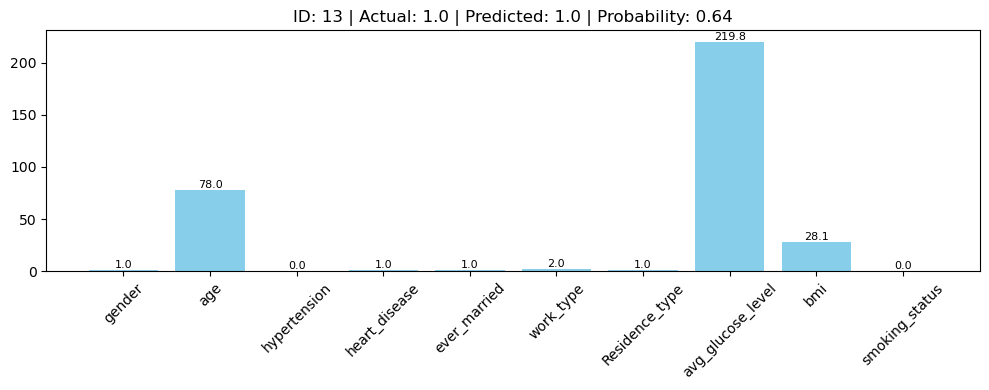

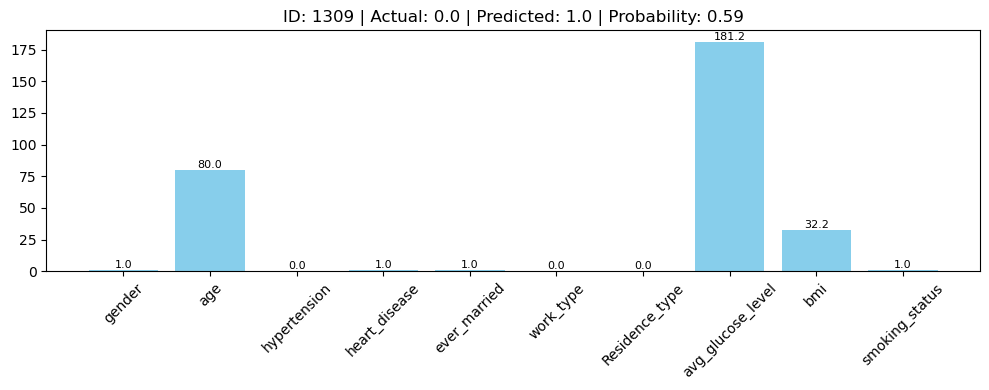

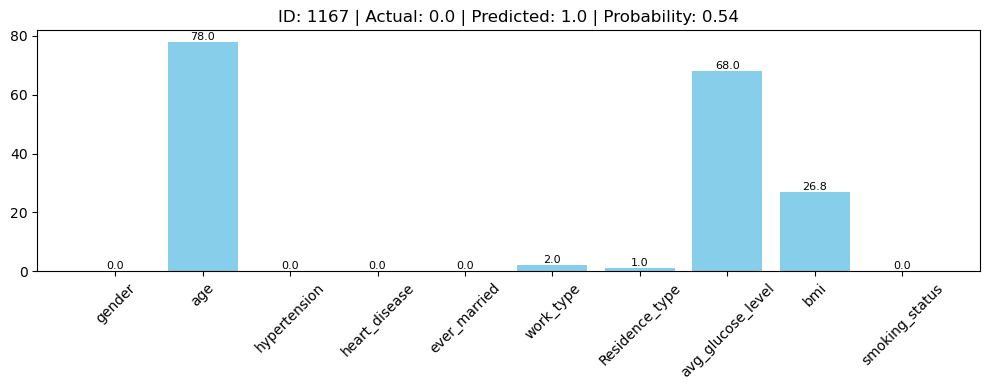

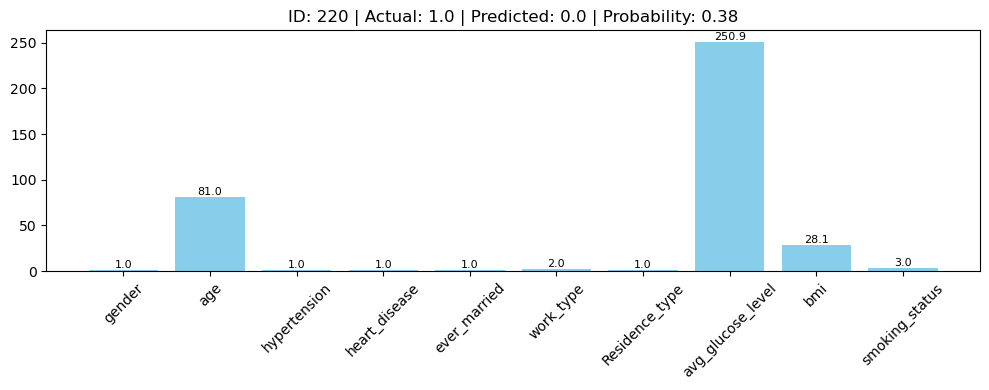

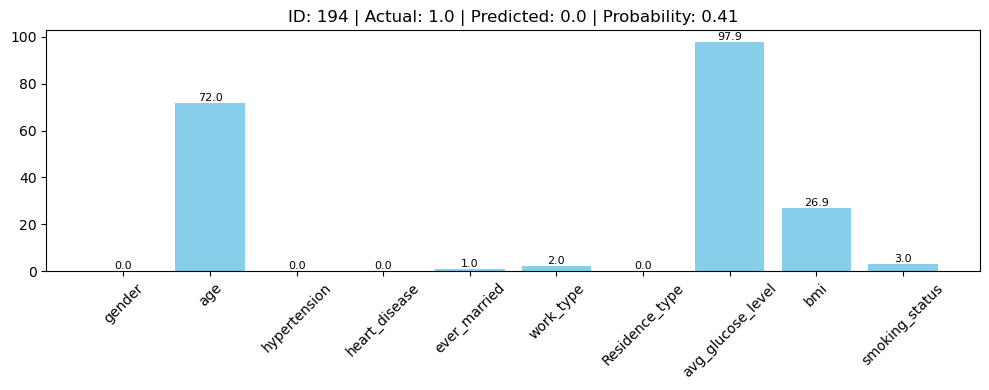

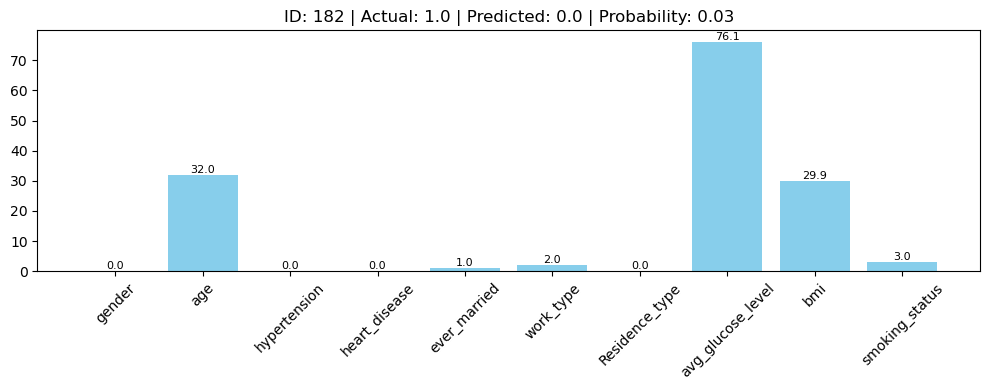

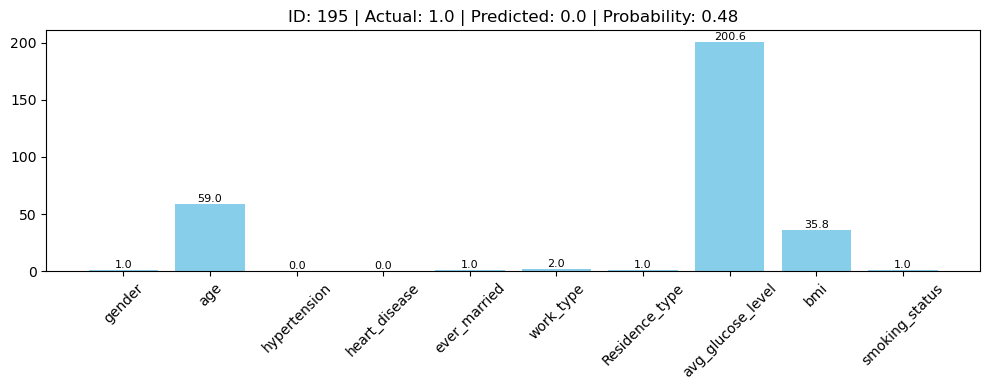

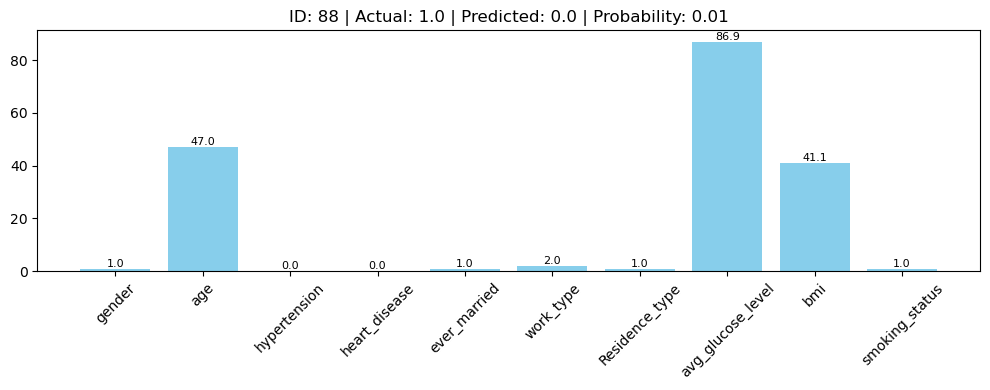

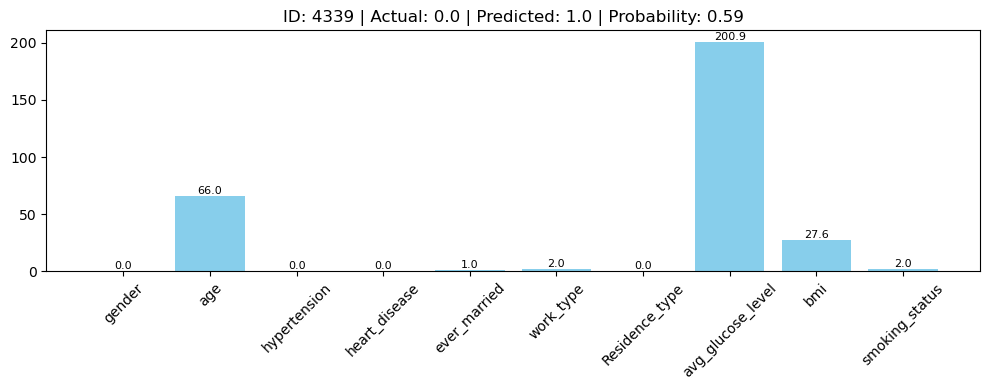

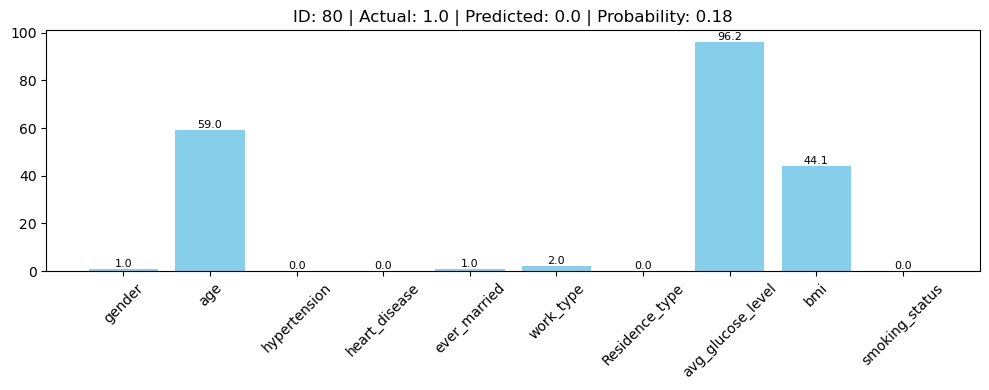

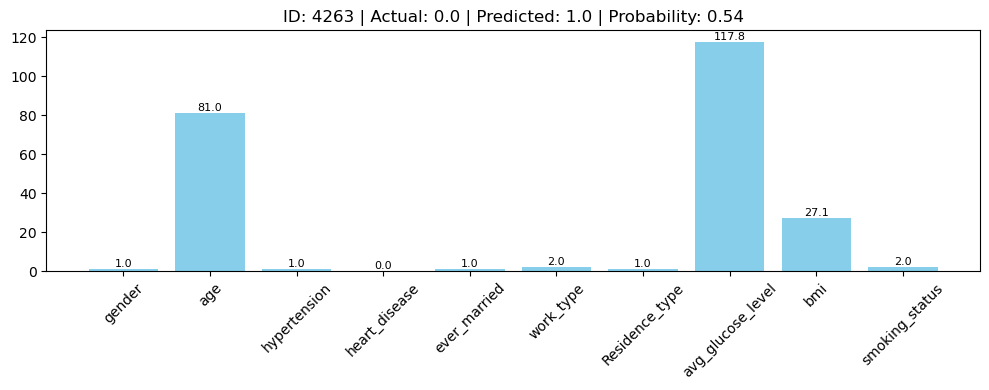

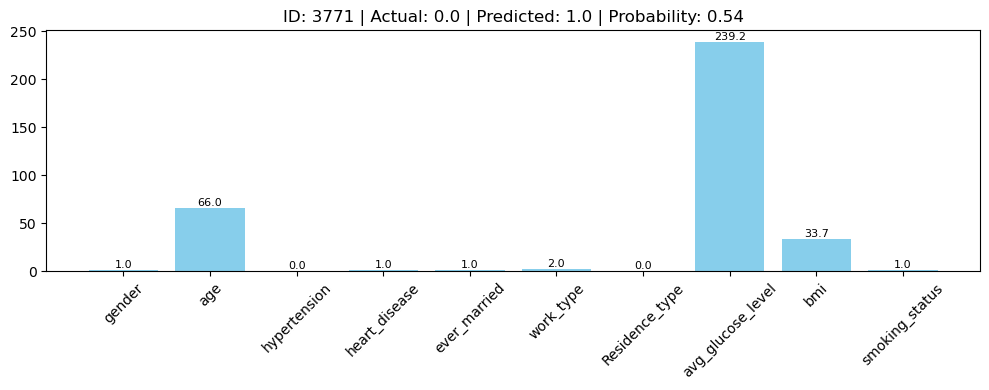

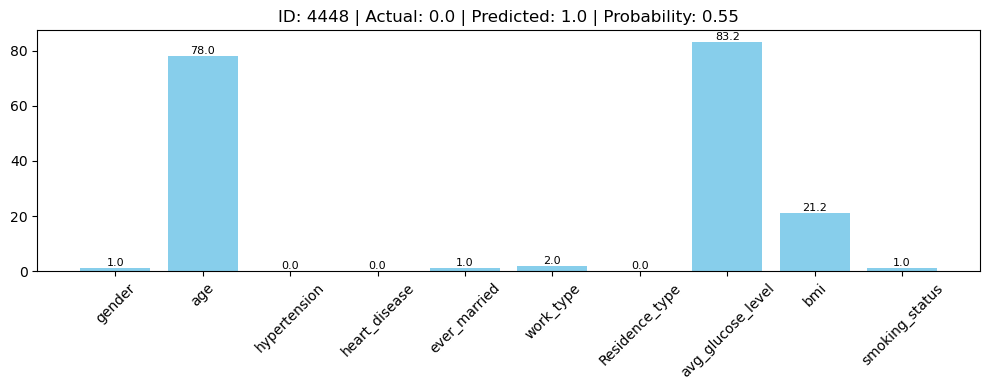

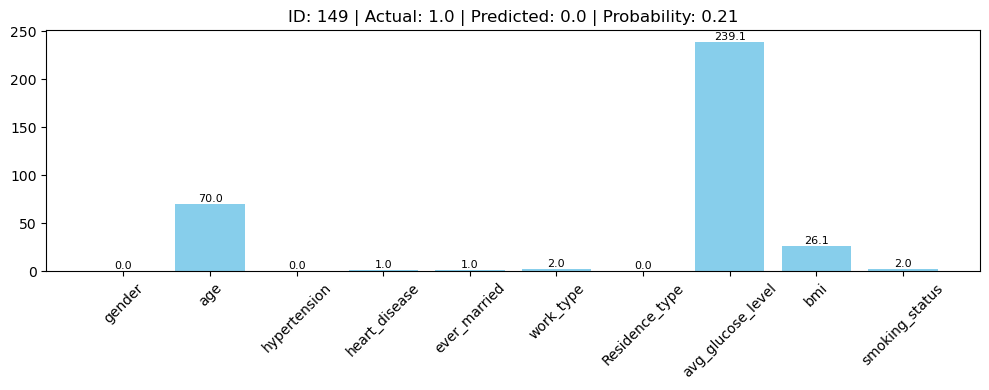

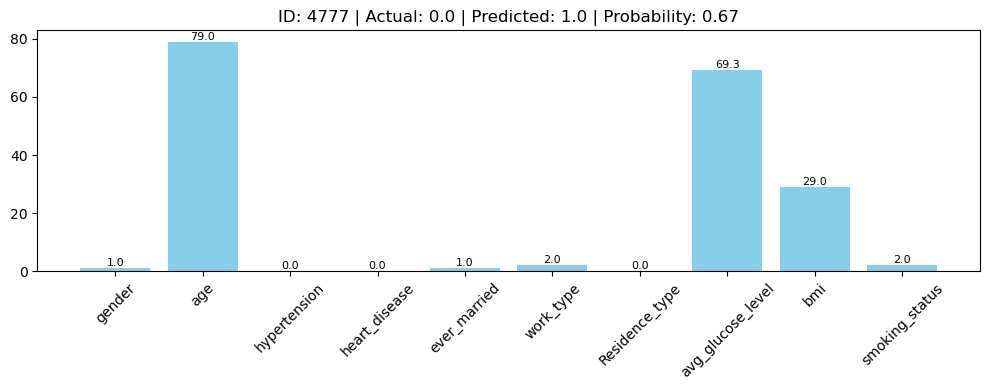

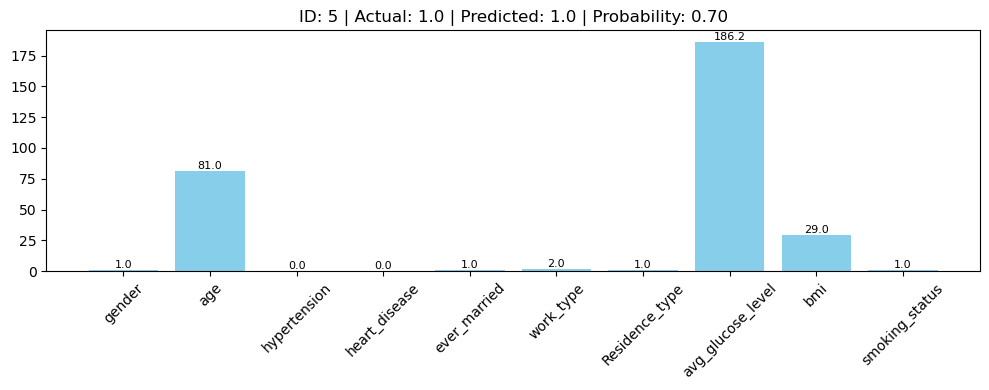

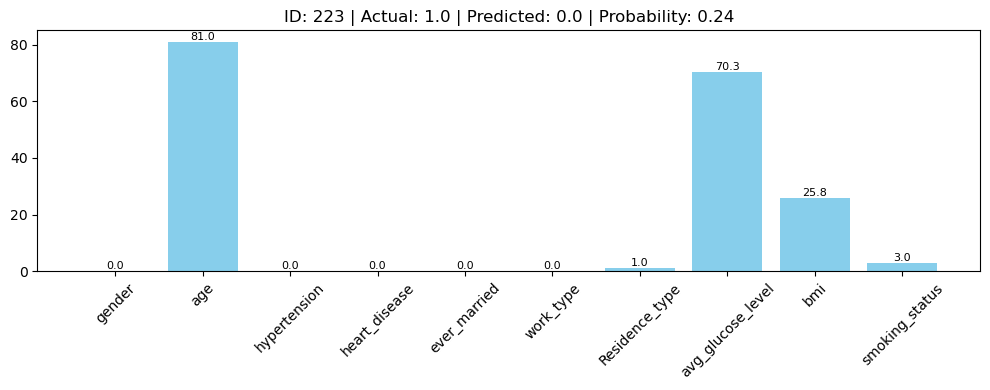

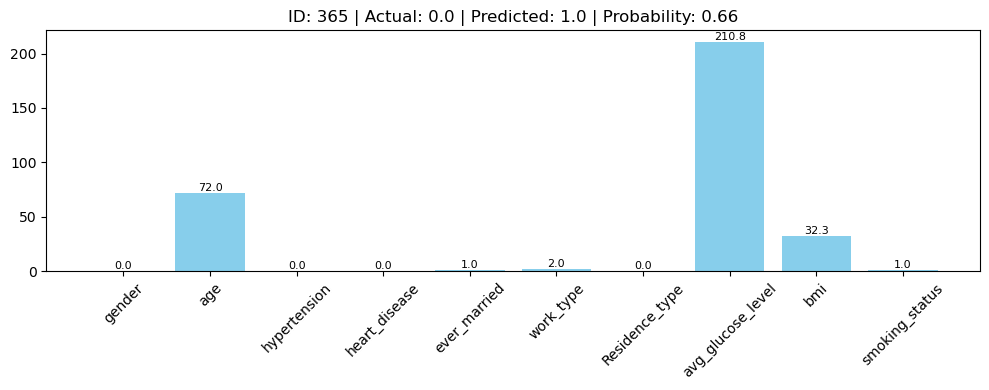

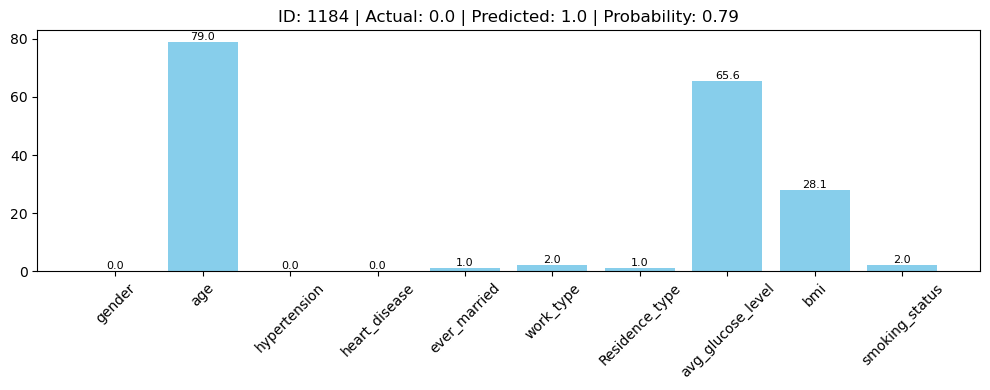

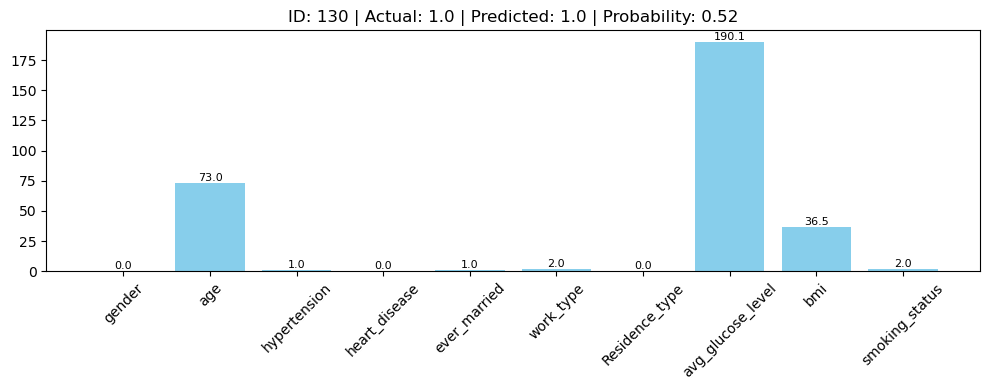

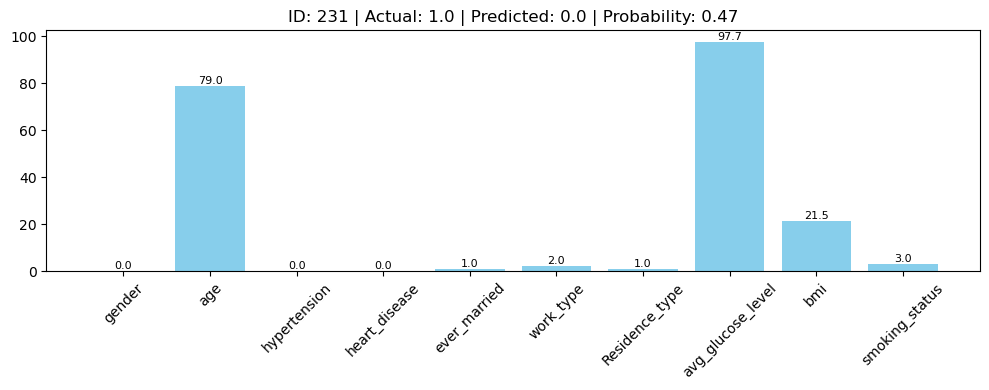

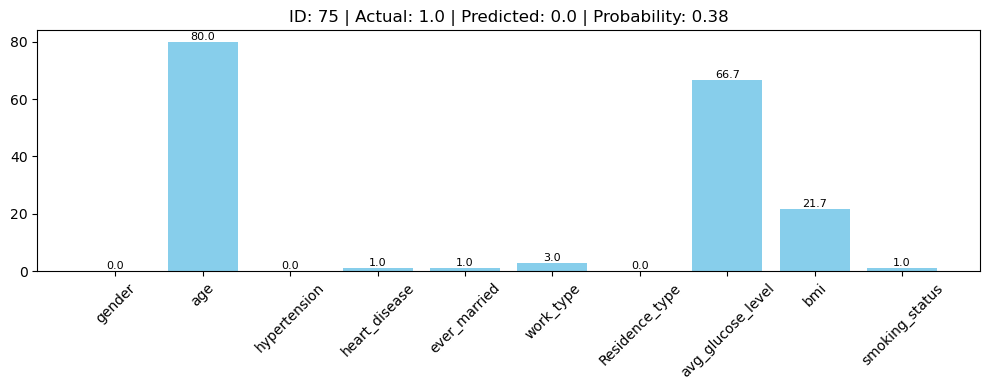

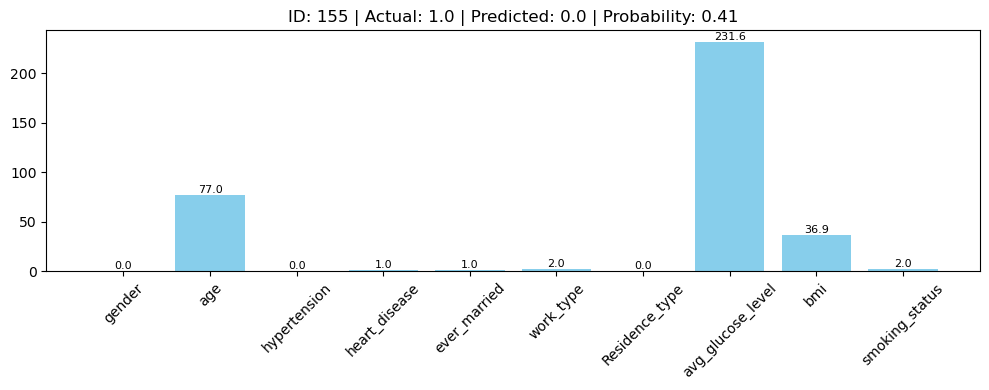

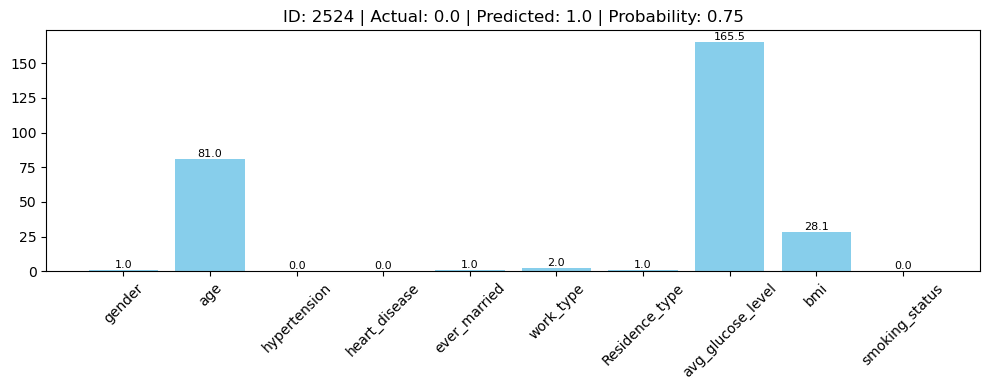

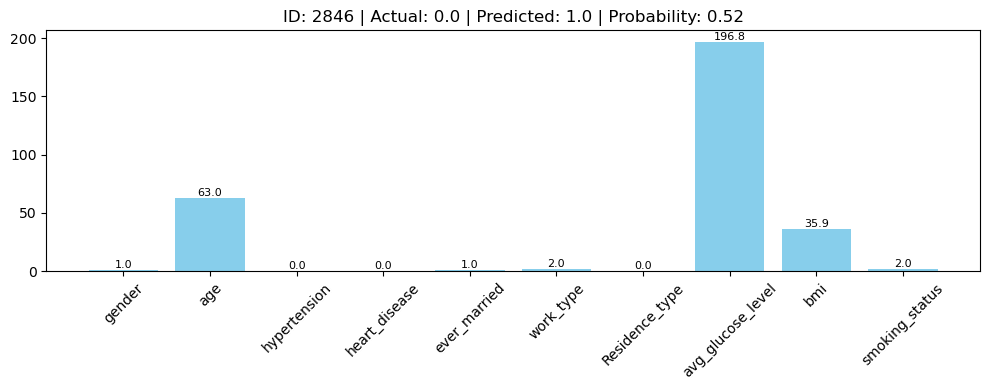

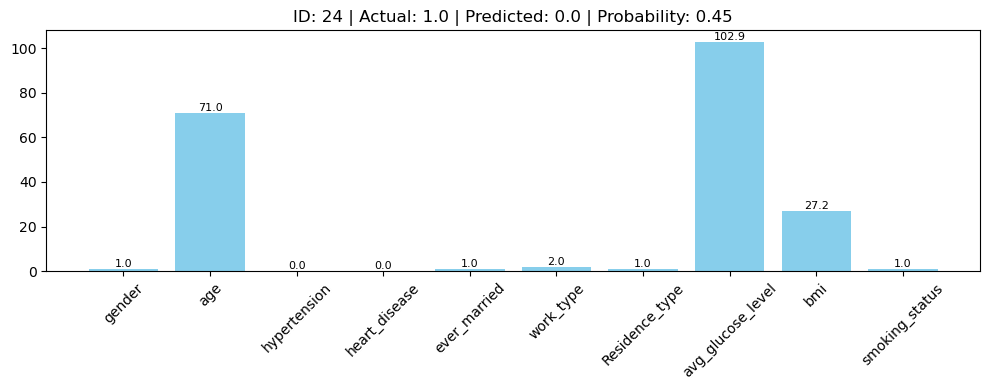

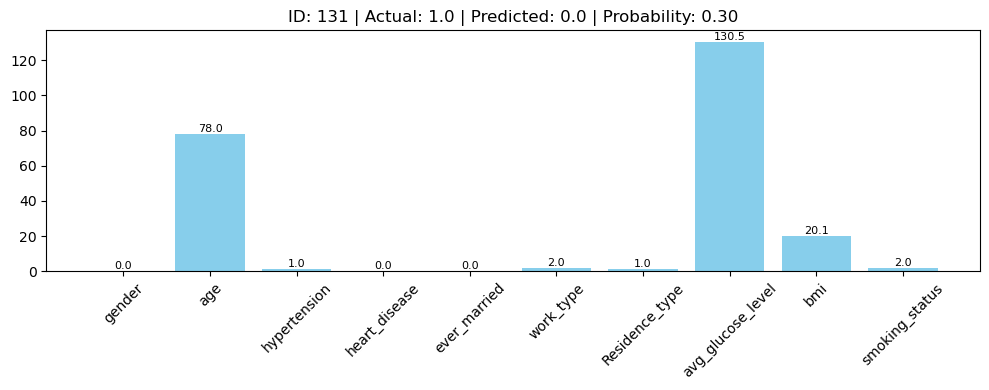

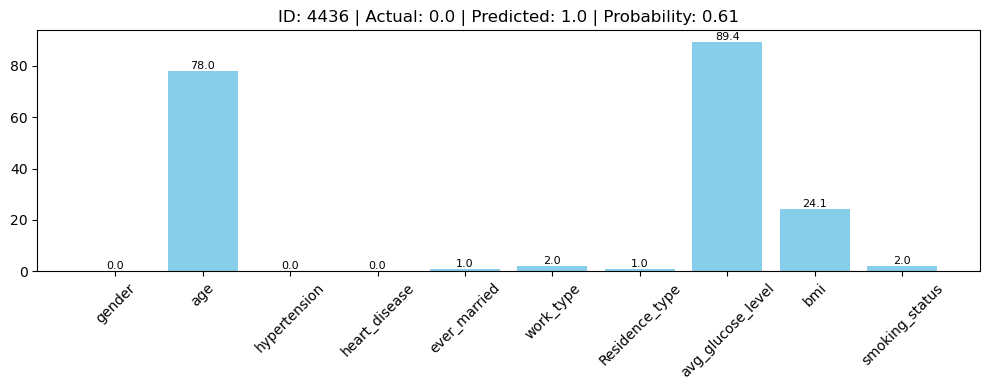

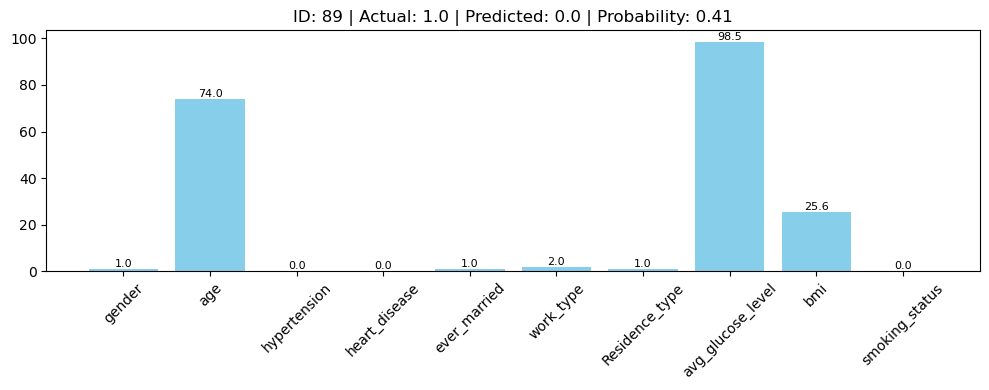

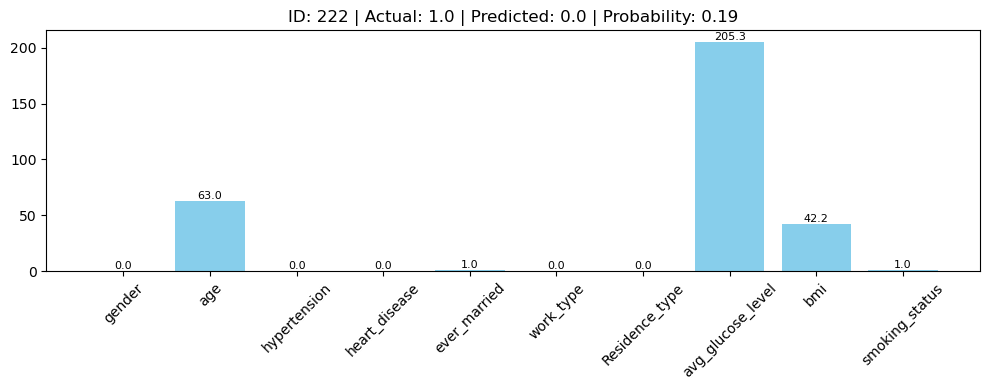

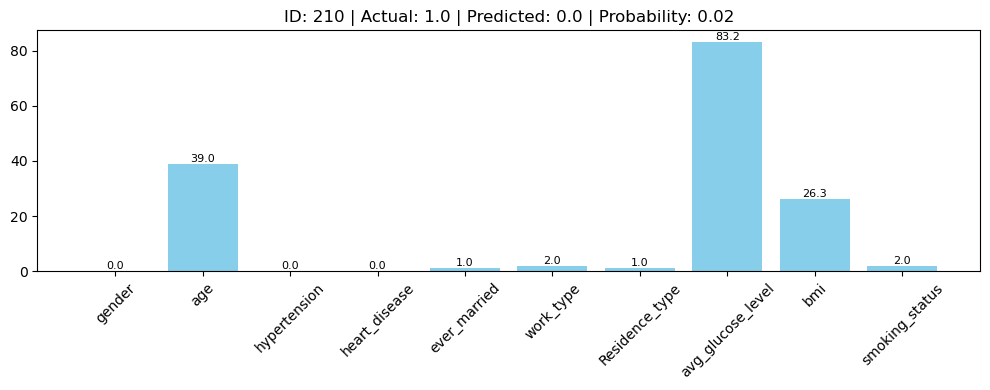

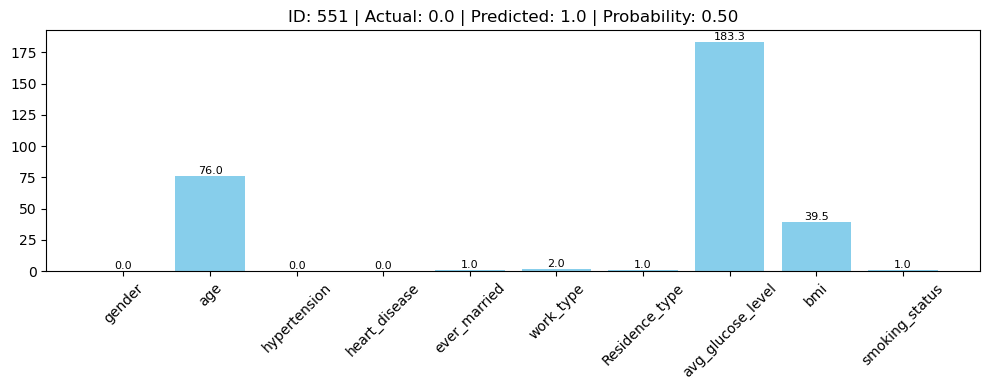

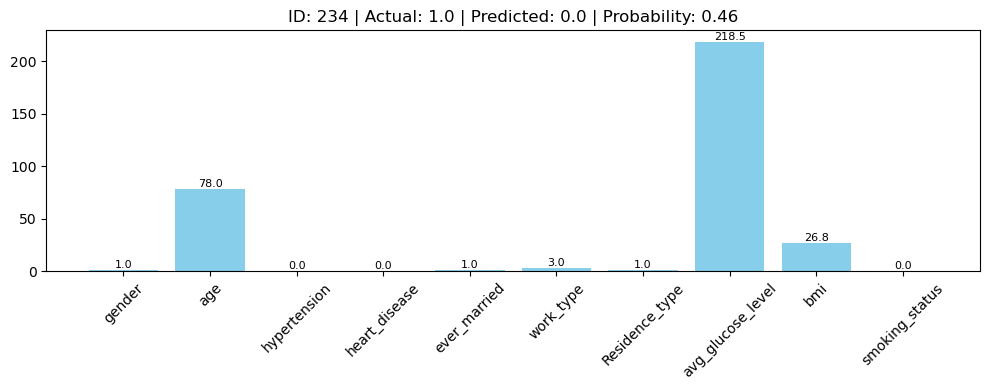

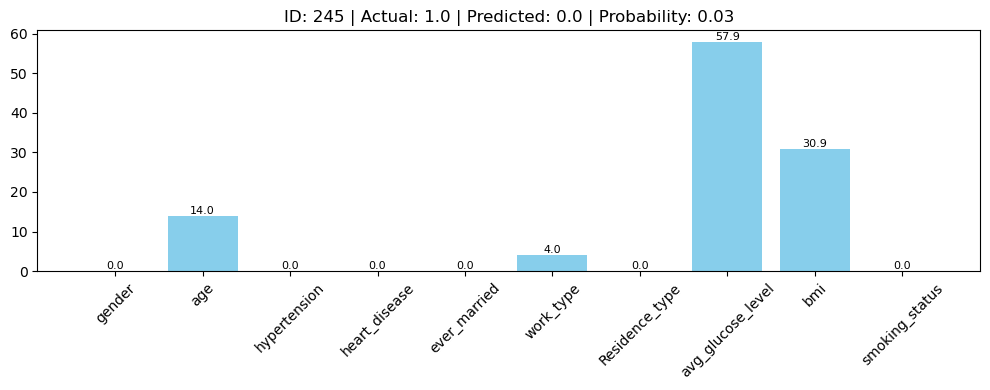

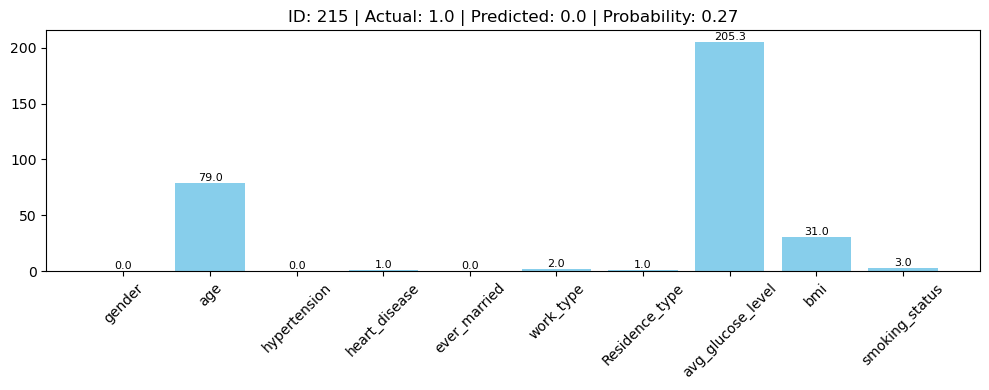

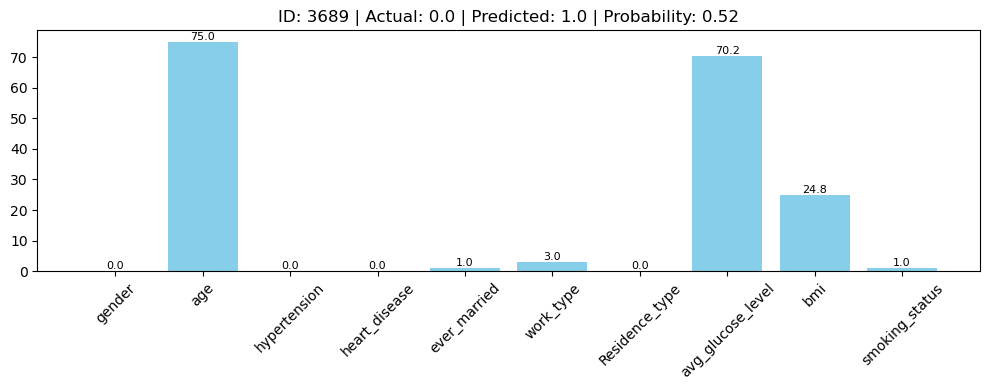

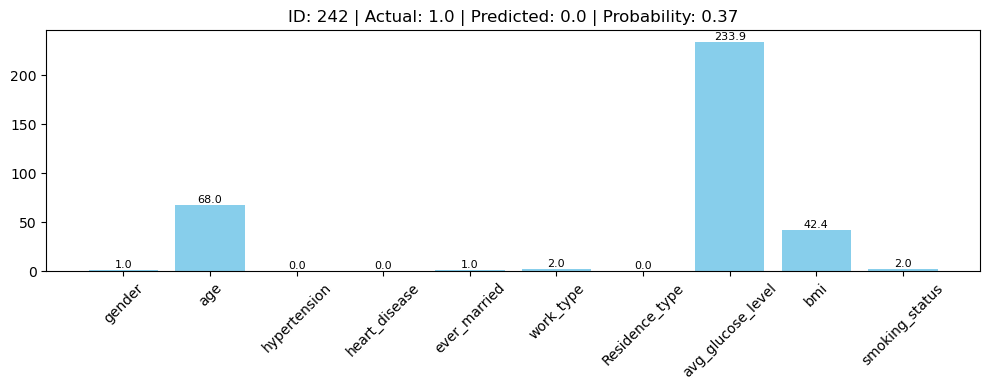

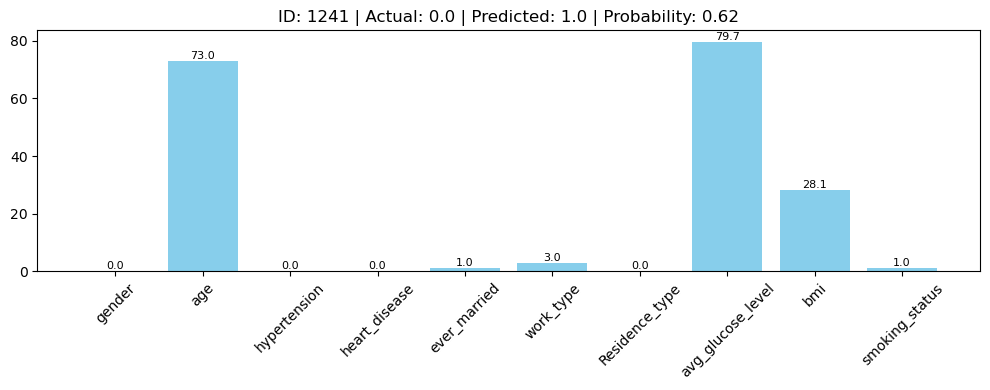

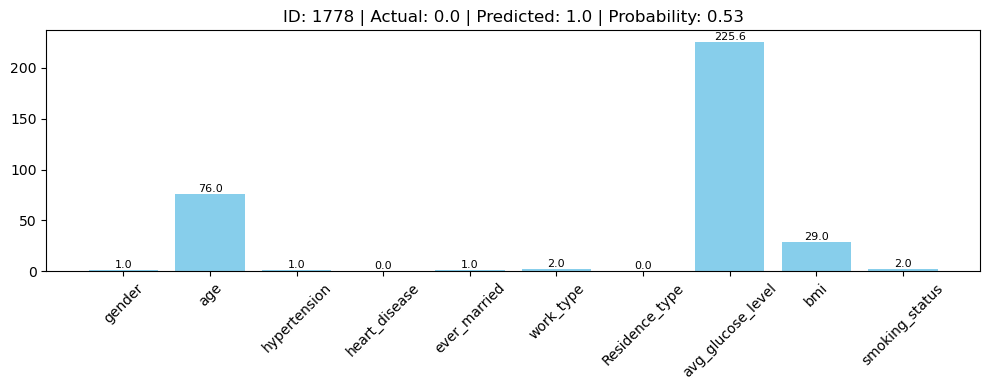

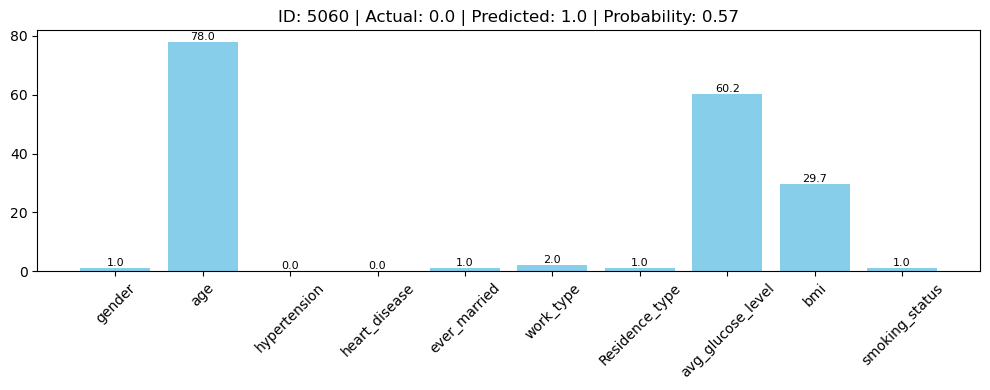

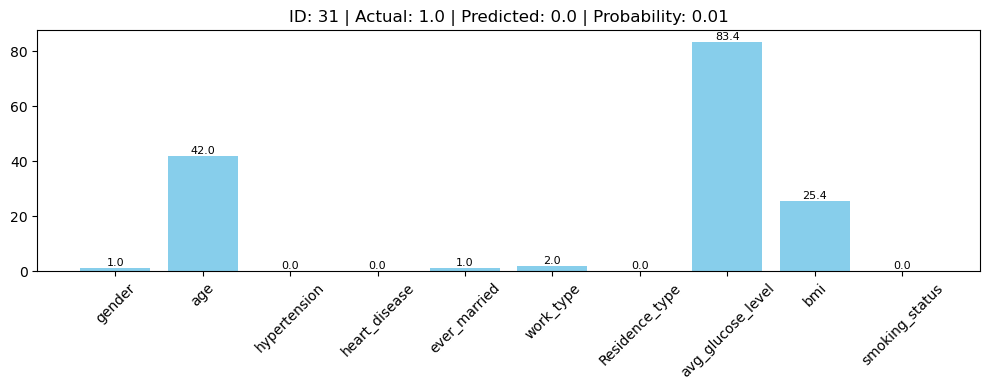

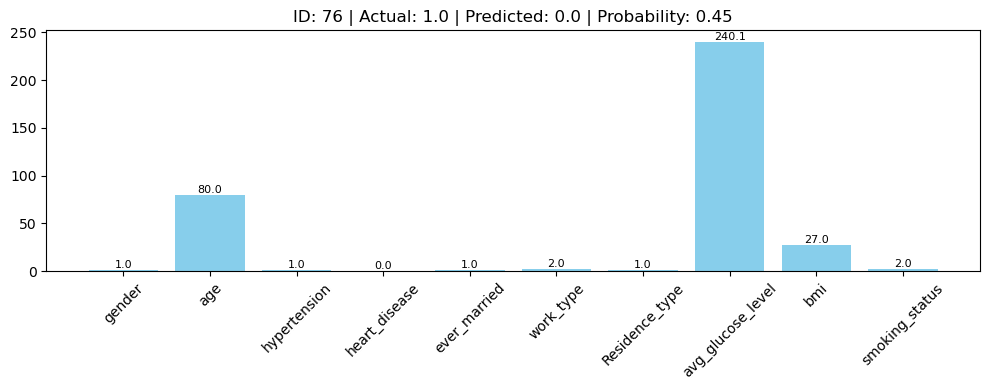

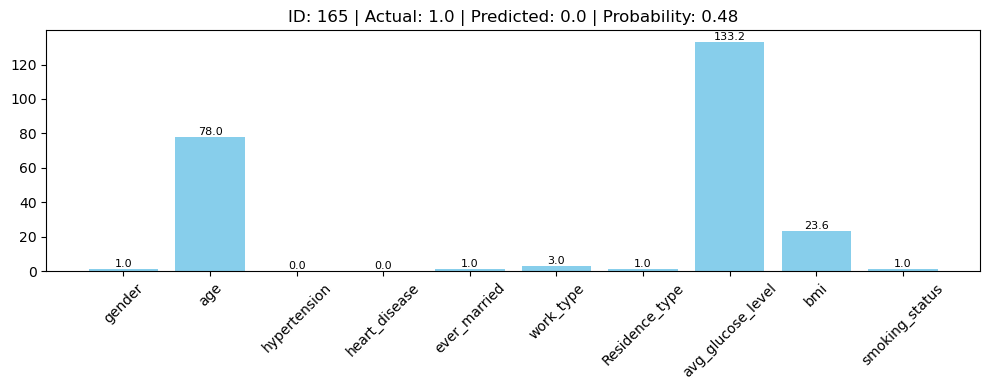

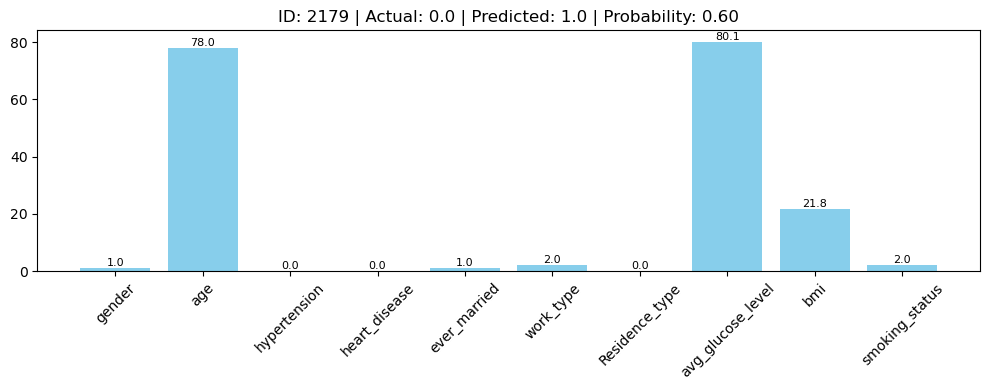

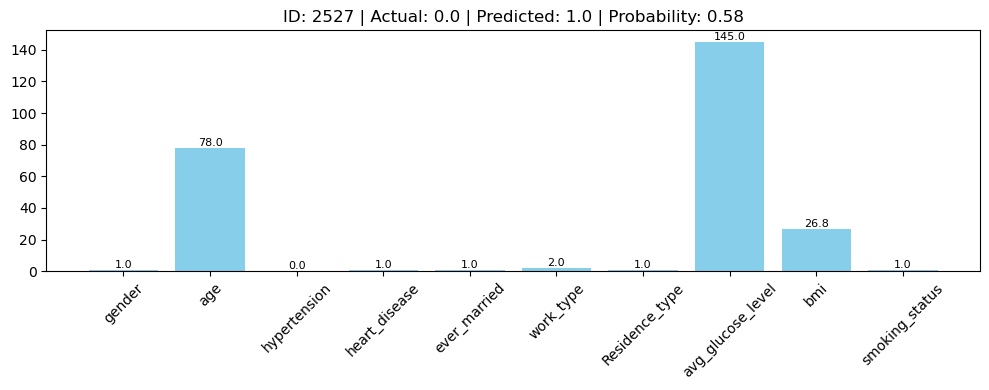

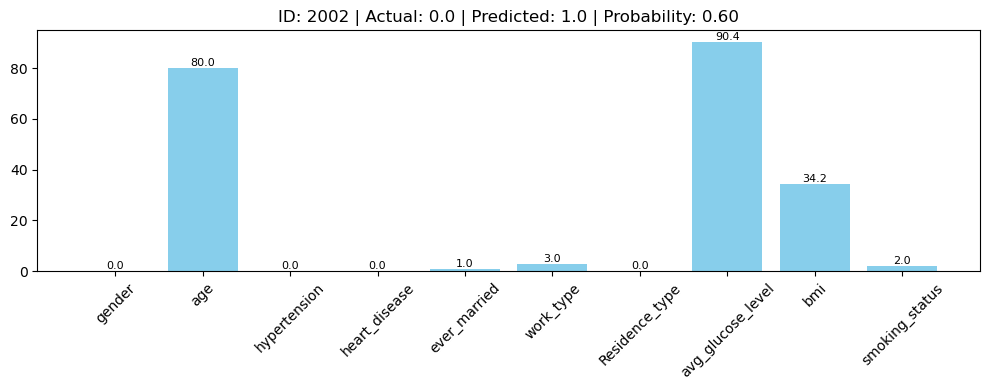

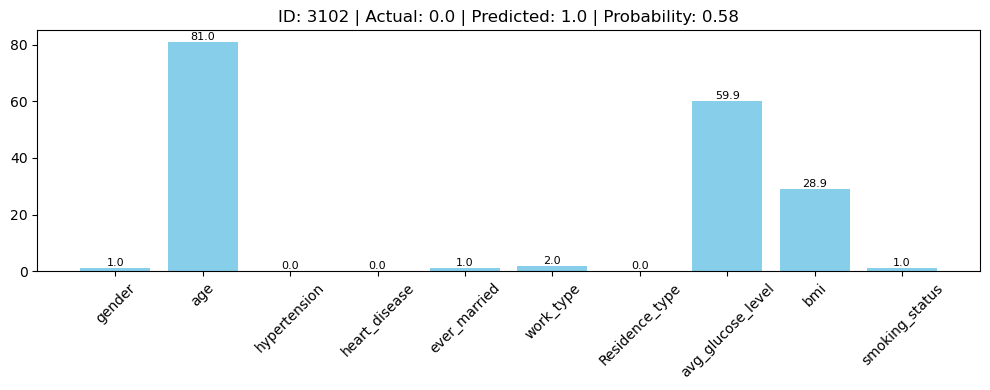

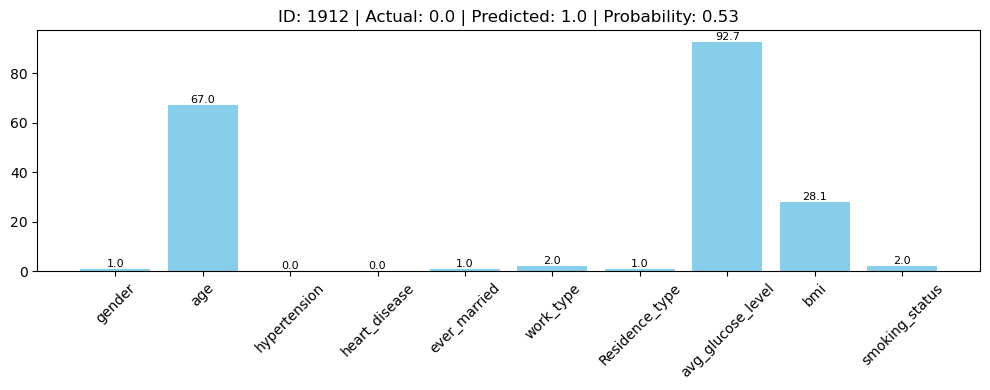

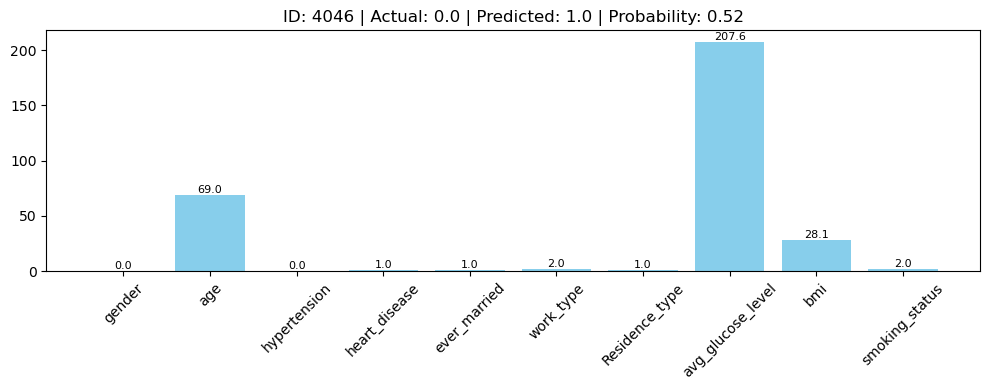

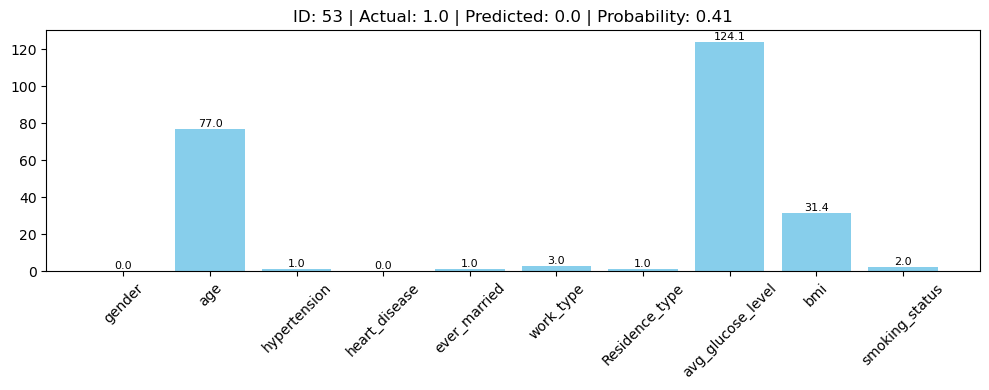

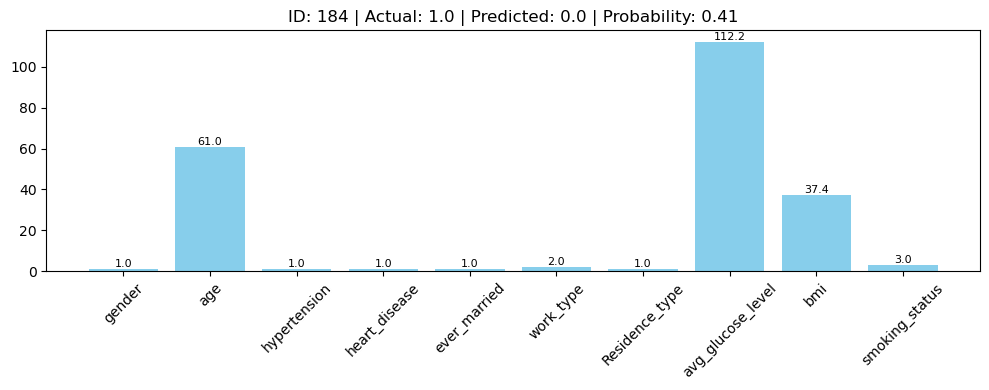

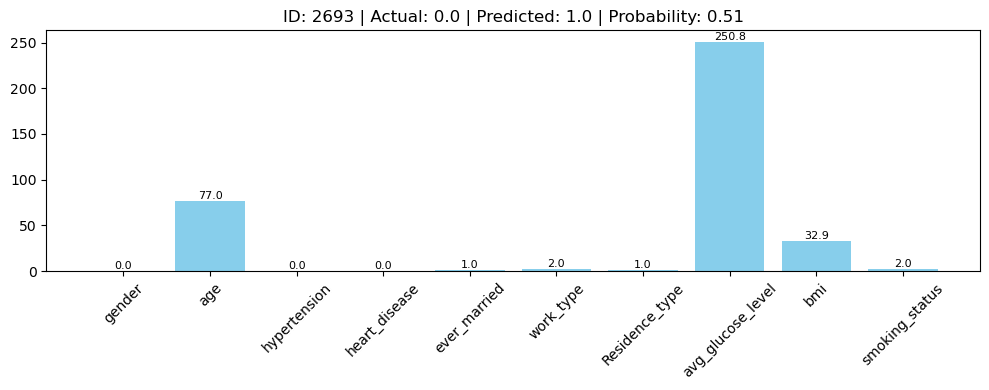

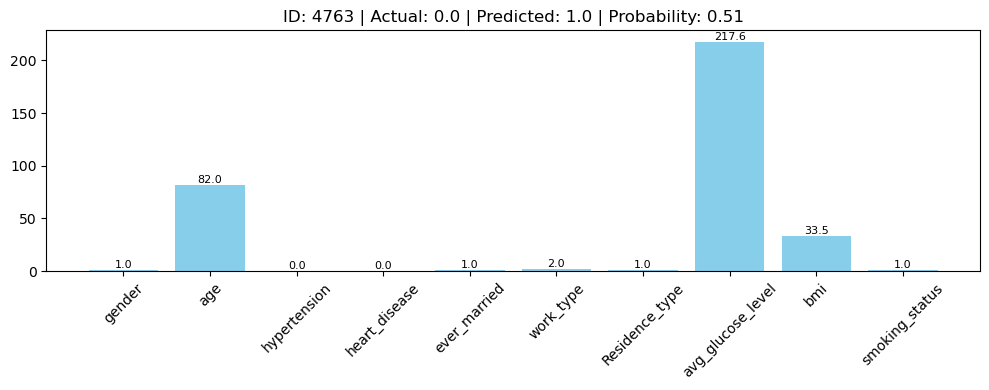

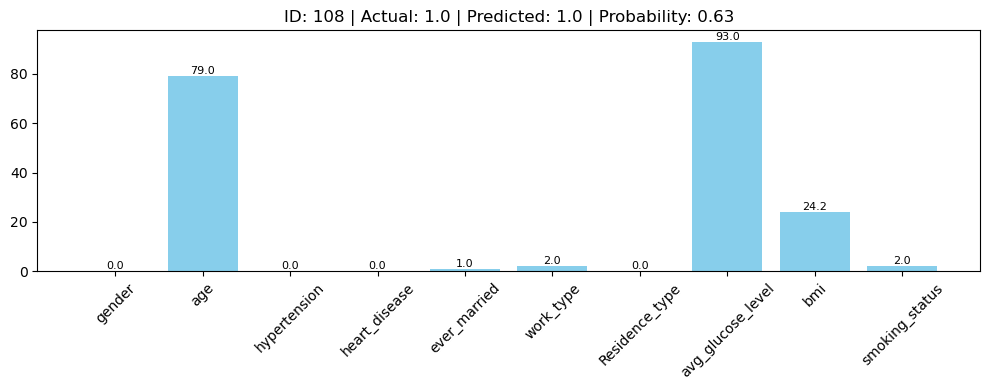

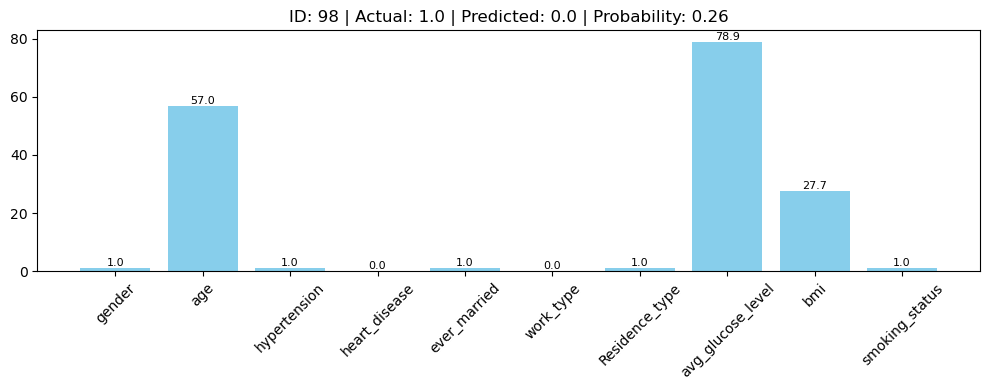

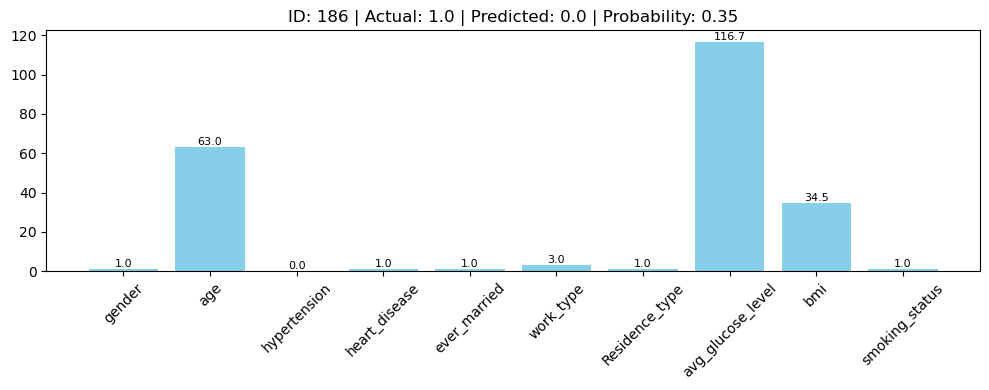

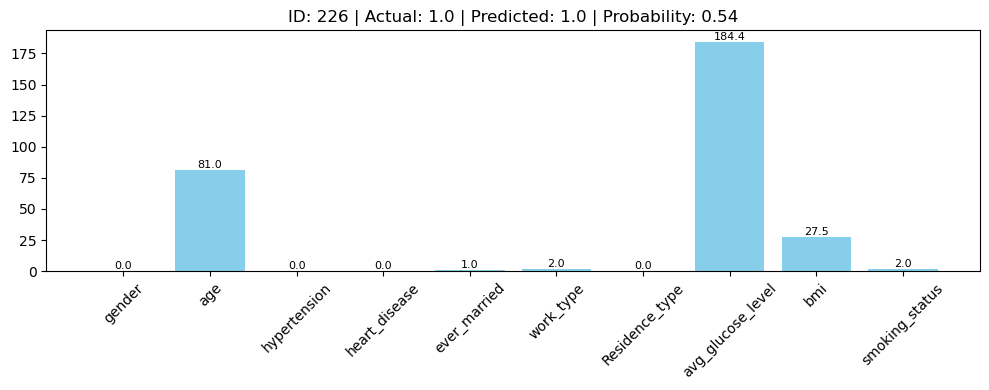

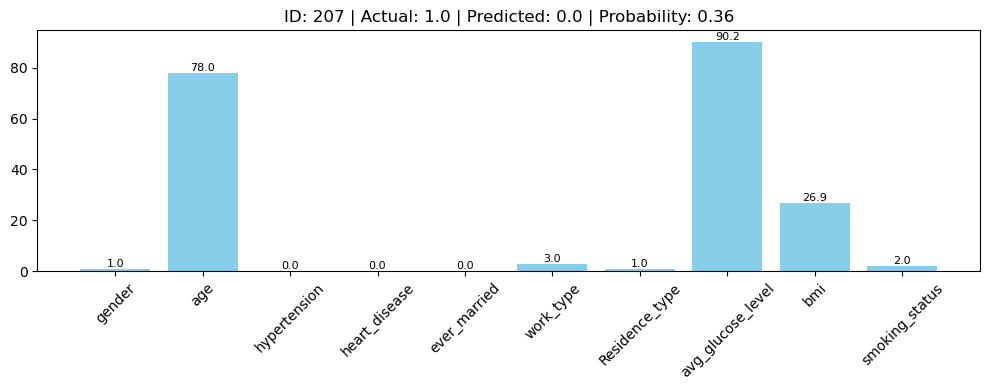

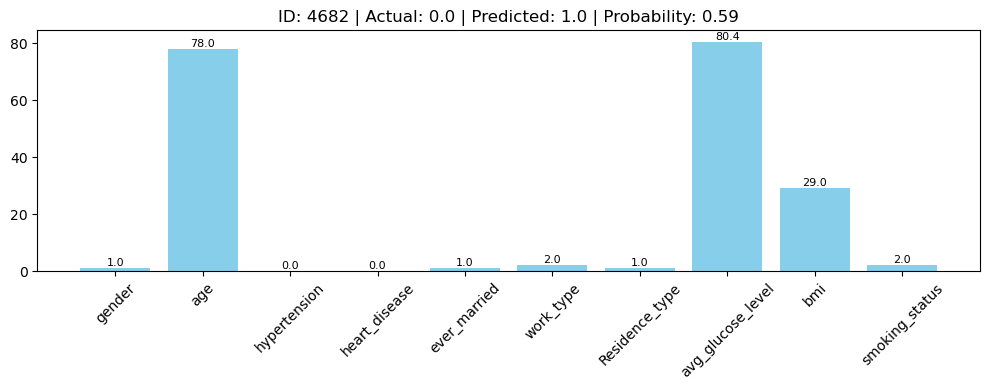

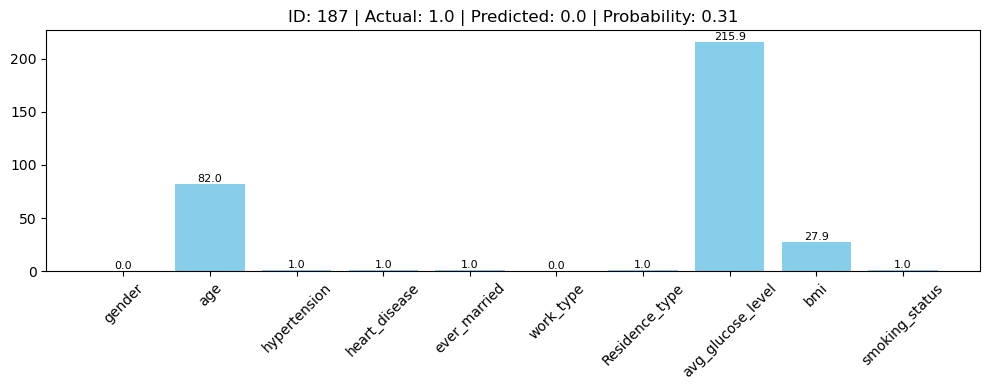

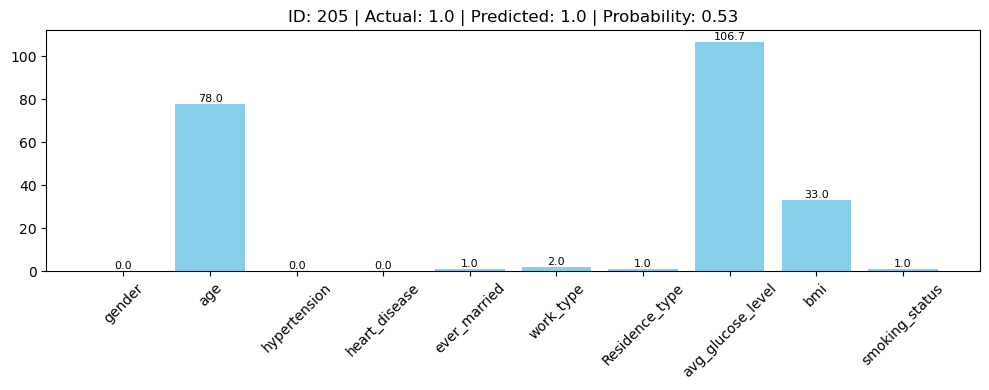

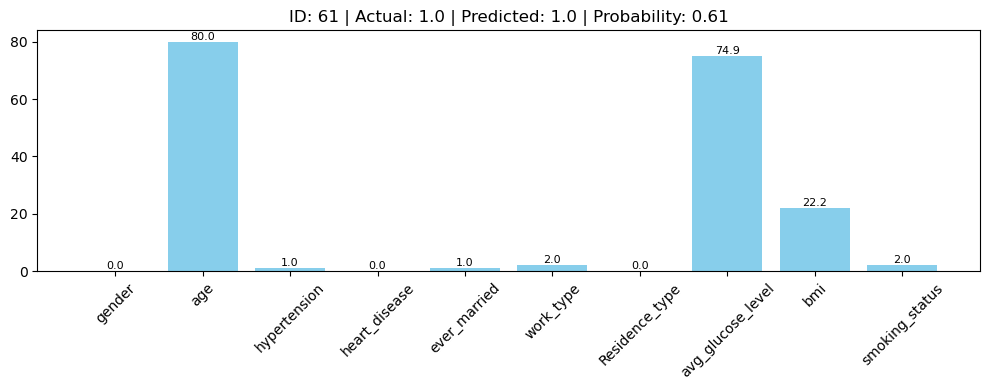

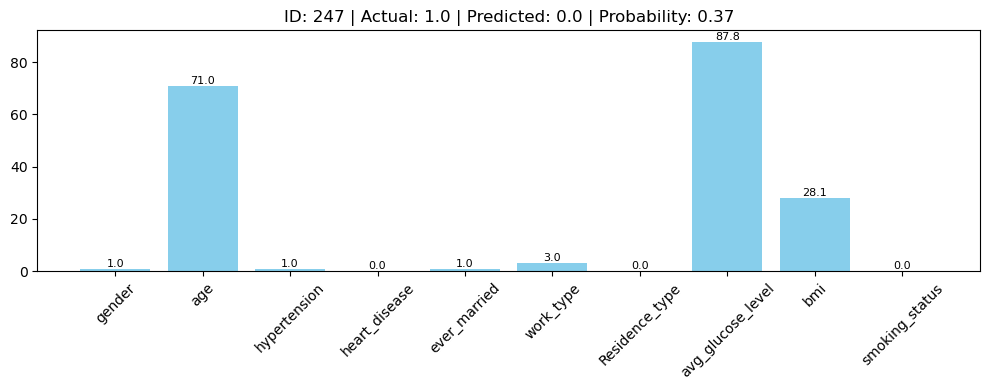

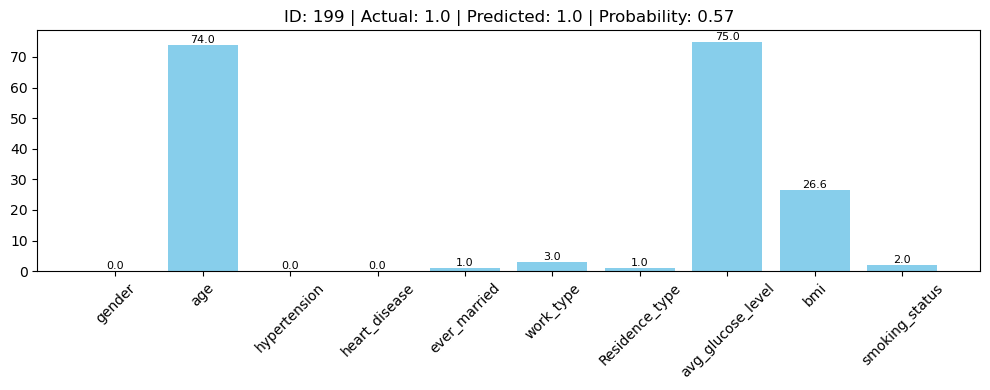

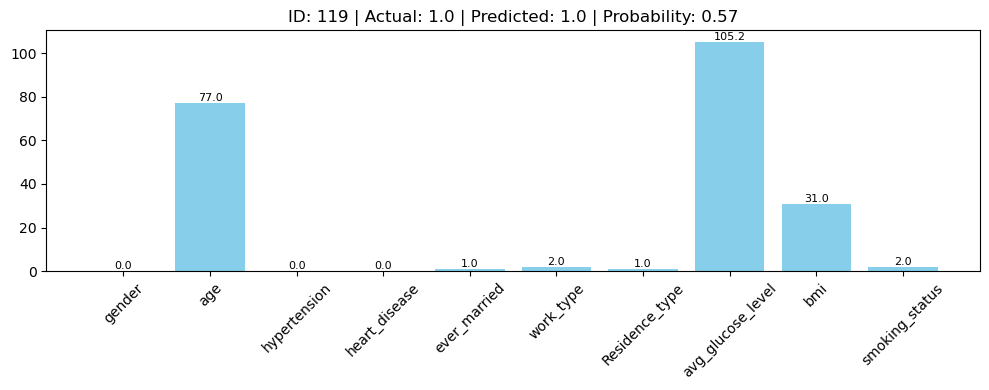

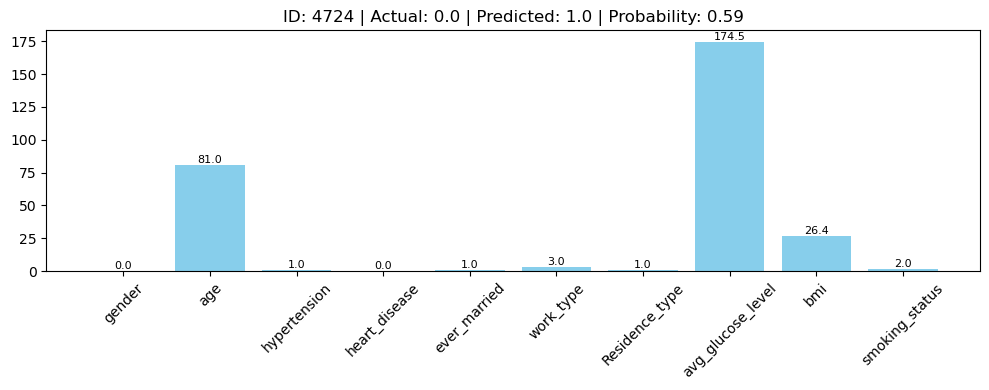

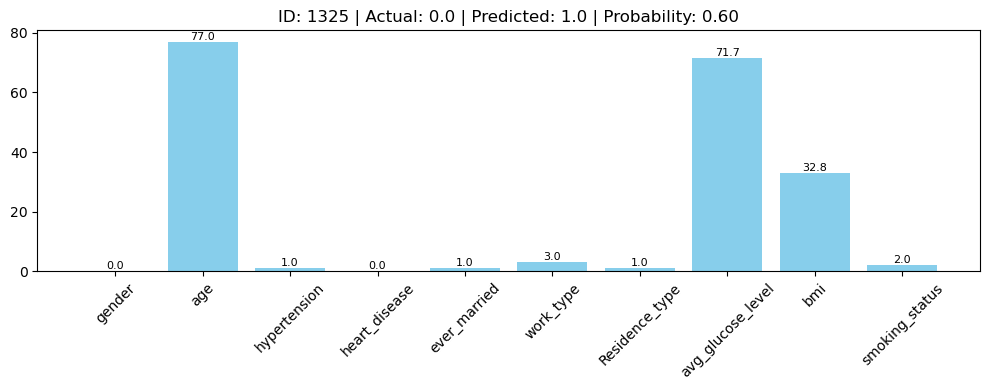

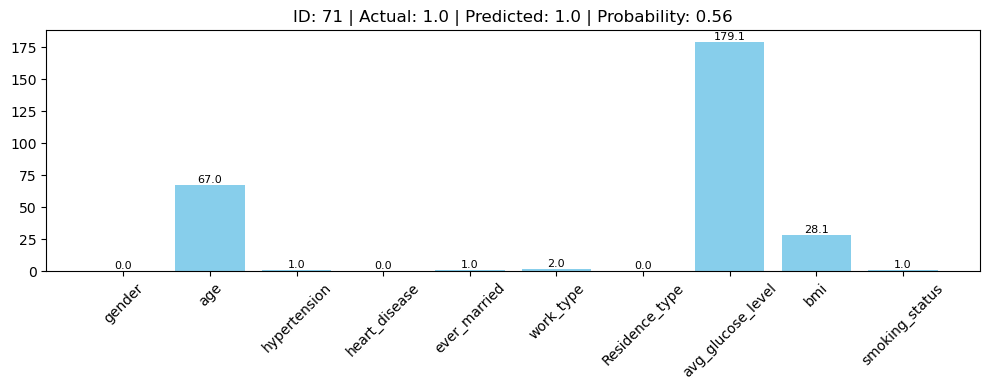

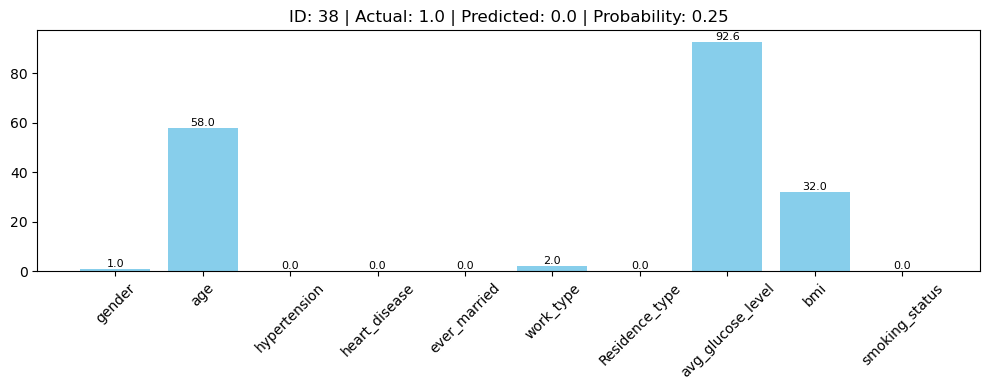

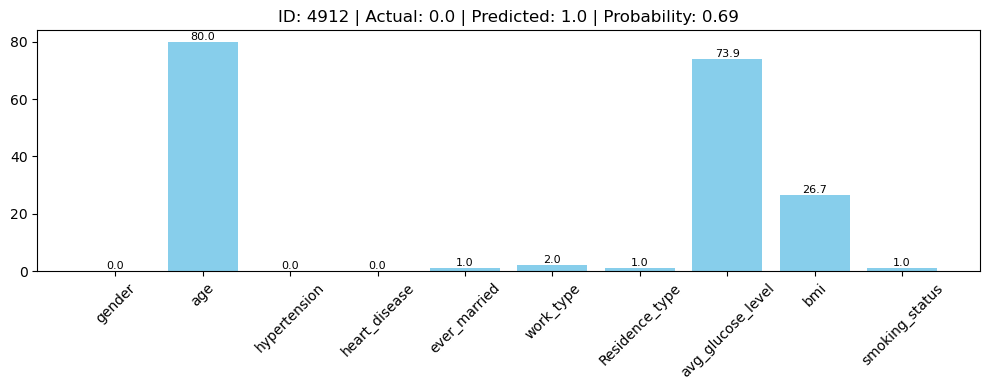

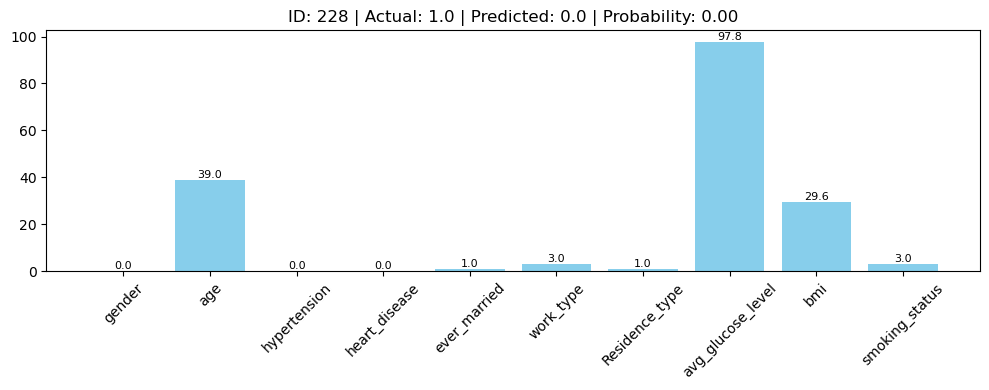

Model and encoders saved successfully.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

df = pd.read_csv(r'C:\Users\Andleeb\Downloads\healthcare-dataset-stroke-data.csv')
df.drop("id", axis=1, inplace=True)

# 2. Handle missing values
df["bmi"].fillna(df["bmi"].median(), inplace=True)

# 3. Encode categorical columns (keep smoking_status and Residence_type)
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop("stroke", axis=1)
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


numeric_features = ["age", "avg_glucose_level", "bmi"]
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), numeric_features)
], remainder="passthrough")

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

# 8. Tune hyperparameters with GridSearchCV
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="roc_auc", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 9. Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# 10. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 12. Create results DataFrame for test set with predictions and probabilities
results_df = X_test.copy()
results_df["Actual_Stroke"] = y_test.values
results_df["Predicted_Stroke"] = y_pred
results_df["Stroke_Probability"] = y_proba

# Filter rows where either actual stroke = 1 or predicted stroke = 1 (cases of interest)
stroke_cases = results_df[(results_df["Actual_Stroke"] == 1) | (results_df["Predicted_Stroke"] == 1)]

# Plot feature values for each case with predicted stroke probability and labels
for idx, row in stroke_cases.iterrows():
    features = row.drop(["Actual_Stroke", "Predicted_Stroke", "Stroke_Probability"])
    actual = row["Actual_Stroke"]
    predicted = row["Predicted_Stroke"]
    prob = row["Stroke_Probability"]

    plt.figure(figsize=(10, 4))
    bars = plt.bar(features.index, features.values, color="skyblue")
    plt.xticks(rotation=45)
    plt.title(f"ID: {idx} | Actual: {actual} | Predicted: {predicted} | Probability: {prob:.2f}")
    
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# 13. Save model and encoders
joblib.dump(best_model, "stroke_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

print("Model and encoders saved successfully.")
